## **Conformal Prediction using Energy Hospital Load**

One example of the NP data is the electricity consumption of a hospital in SF. It has hourly reservation for the entire year of 2015.

### Library Setup
Requires Python 3.9+

In [1]:
!python --version

Python 3.9.12


Install NeuralProphet from scratch

In [2]:
if "google.colab" in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git  # may take a while
    # !pip install neuralprophet  # much faster, but may not have the latest upgrades/bugfixes

In [3]:
# !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
# !pip install neuralprophet  # much faster, but may not have the latest upgrades/bugfixes

### Extract Data and Split Data into Train, Val, Cal, and Test


**Extract Data From GitHub**

In [4]:
import numpy as np
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level, set_random_seed

set_log_level("ERROR")

In [5]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
file = "energy/SF_hospital_load.csv"

In [6]:
data_df = pd.read_csv(data_location + file)

In [7]:
data_df.head(5)

ds           y
0  2015-01-01 01:00:00  778.007969
1  2015-01-01 02:00:00  776.241750
2  2015-01-01 03:00:00  779.357338
3  2015-01-01 04:00:00  778.737196
4  2015-01-01 05:00:00  787.835835

In [8]:
data_df.tail(5)

ds           y
8755  2015-12-31 20:00:00  845.563081
8756  2015-12-31 21:00:00  827.530521
8757  2015-12-31 22:00:00  829.256300
8758  2015-12-31 23:00:00  813.937205
8759  2016-01-01 00:00:00  815.588584

**Split data into train, val, cal, and test in that order**

Do we need to instantiate a NP model `m` in order to split the df into train and test? If so, does the NP params make any diff to the outcome of this split? I'm presuming no atm.

In [9]:
m = NeuralProphet()

In [10]:
train_df, test_df = m.split_df(data_df, freq="H", valid_p=1.0 / 16)
train_df, cal_df = m.split_df(train_df, freq="H", valid_p=1.0 / 11)
train_df, val_df = m.split_df(train_df, freq="H", valid_p=1.0 / 10)

In [11]:
train_df.shape, val_df.shape, cal_df.shape, test_df.shape

((6721, 2), (746, 2), (746, 2), (547, 2))

In [12]:
print(f"Train set time range:        {train_df['ds'].min()} - {train_df['ds'].max()}")
print(f"Validation set time range:   {val_df['ds'].min()} - {val_df['ds'].max()}")
print(f"Calibration set time range:  {cal_df['ds'].min()} - {cal_df['ds'].max()}")
print(f"Test set time range:         {test_df['ds'].min()} - {test_df['ds'].max()}")

Train set time range:        2015-01-01 01:00:00 - 2015-10-08 01:00:00
Validation set time range:   2015-10-08 02:00:00 - 2015-11-08 03:00:00
Calibration set time range:  2015-11-08 04:00:00 - 2015-12-09 05:00:00
Test set time range:         2015-12-09 06:00:00 - 2016-01-01 00:00:00


**Plot train_df**

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [14]:
x_size = 16
y_size = 6
figsize = (x_size, y_size)

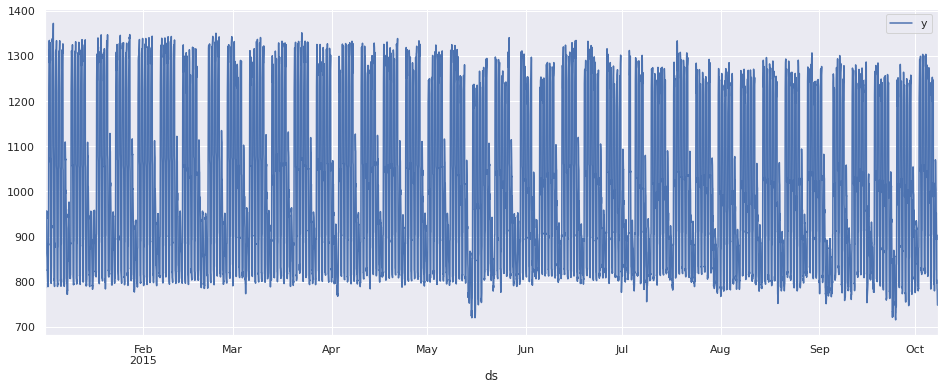

In [15]:
train_df.set_index("ds").plot(figsize=figsize);

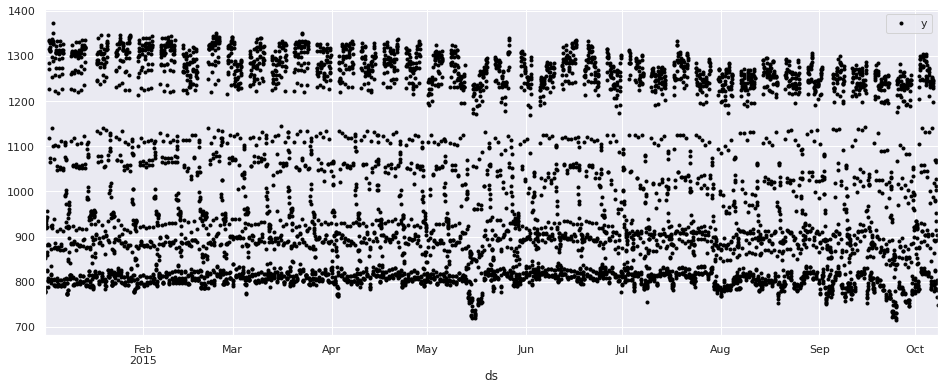

In [16]:
train_df.set_index("ds").plot(marker=".", linestyle="none", colormap="gray", figsize=figsize);

### Train the NP Models (with 5th/95th Quantiles)
- `m1`: NP with default features
- `m2`: NP with parametric time-based features (like in Facebook Prophet)
- `m3`: NP with 1-layer AR
- `m4`: NP with 4-layer deep AR

In [17]:
quantile_lo, quantile_hi = 0.05, 0.95
quantiles = [quantile_lo, quantile_hi]
n_lags = 3 * 24

In [18]:
m1 = NeuralProphet(
    quantiles=quantiles,
)
m2 = NeuralProphet(
    weekly_seasonality=6,
    daily_seasonality=10,
    trend_reg=1,
    learning_rate=0.01,
    quantiles=quantiles,
)
m3 = NeuralProphet(
    growth="off",
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=n_lags,
    ar_reg=1,
    learning_rate=0.01,
    quantiles=quantiles,
)
m4 = NeuralProphet(
    growth="off",
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=n_lags,
    num_hidden_layers=4,
    d_hidden=32,
    learning_rate=0.003,
    quantiles=quantiles,
)

Train the 4 models. You can either concatonate the train and val set into one full training set or use the val set separately for hyperparameter tuning. I recommend trying both ways to see how to performance evaluation metrics change.

In [19]:
%%time
random_seed = 0

# Conconate train_df and val_df as full training set
set_random_seed(random_seed)
metrics1 = m1.fit(pd.concat([train_df, val_df]), freq="H")
set_random_seed(random_seed)
metrics2 = m2.fit(pd.concat([train_df, val_df]), freq="H")
set_random_seed(random_seed)
metrics3 = m3.fit(pd.concat([train_df, val_df]), freq="H")
set_random_seed(random_seed)
metrics4 = m4.fit(pd.concat([train_df, val_df]), freq="H")

# Use val_df for validation
# set_random_seed(random_seed)
# metrics1 = m1.fit(train_df, freq='H', validation_df=val_df)
# set_random_seed(random_seed)
# metrics2 = m2.fit(train_df, freq='H', validation_df=val_df)
# set_random_seed(random_seed)
# metrics3 = m3.fit(train_df, freq='H', validation_df=val_df)
# set_random_seed(random_seed)
# metrics4 = m4.fit(train_df, freq='H', validation_df=val_df)
# metrics4 = m4.fit(train_df, freq='H', validation_df=val_df, progress='plot')

Finding best initial lr:   0%|          | 0/246 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

CPU times: user 7min 54s, sys: 1.03 s, total: 7min 55s
Wall time: 8min 42s


In [20]:
metrics1.tail(1)

MAE       RMSE      Loss  RegLoss  epoch
110  64.864601  80.605118  0.008875      0.0    110

In [21]:
metrics2.tail(1)

MAE       RMSE      Loss  RegLoss  epoch
110  45.252567  62.495289  0.005778      0.0    110

In [22]:
metrics3.tail(1)

MAE       RMSE      Loss   RegLoss  epoch
110  23.764839  35.071205  0.003226  0.001175    110

In [23]:
metrics4.tail(1)

MAE      RMSE      Loss  RegLoss  epoch
110  7.063153  10.06792  0.000155      0.0    110

**Get forecasts of out-of-sample (OOS) test_df**

In [24]:
forecast1 = m1.predict(test_df)
forecast3 = m3.predict(test_df)

Predicting: 234it [00:00, ?it/s]

Predicting: 232it [00:00, ?it/s]

In [25]:
forecast1.head()

ds            y        yhat1   yhat1 5.0%  yhat1 95.0%  \
0 2015-12-09 06:00:00   803.410865   988.667847   909.531128  1087.552490   
1 2015-12-09 07:00:00   868.264194  1089.195190   994.171021  1190.007812   
2 2015-12-09 08:00:00   975.752982  1146.549438  1057.149414  1236.459473   
3 2015-12-09 09:00:00   983.268943  1155.055664  1078.084351  1243.069580   
4 2015-12-09 10:00:00  1095.825986  1145.486328  1073.584595  1236.622803   

         trend  season_weekly  season_daily  
0  1031.482666     -35.462124     -7.352807  
1  1031.499756     -43.487553    101.183006  
2  1031.516724     -51.679520    166.712158  
3  1031.533813     -59.992954    183.514786  
4  1031.550781     -68.380142    182.315750

In [26]:
forecast3.head()

ds            y  yhat1  yhat1 5.0%  yhat1 95.0%  ar1  trend
0 2015-12-09 06:00:00   803.410865    NaN         NaN          NaN  NaN    NaN
1 2015-12-09 07:00:00   868.264194    NaN         NaN          NaN  NaN    NaN
2 2015-12-09 08:00:00   975.752982    NaN         NaN          NaN  NaN    NaN
3 2015-12-09 09:00:00   983.268943    NaN         NaN          NaN  NaN    NaN
4 2015-12-09 10:00:00  1095.825986    NaN         NaN          NaN  NaN    NaN

In [27]:
forecast3[forecast3["yhat1"].isna()]

ds            y  yhat1  yhat1 5.0%  yhat1 95.0%  ar1  \
0  2015-12-09 06:00:00   803.410865    NaN         NaN          NaN  NaN   
1  2015-12-09 07:00:00   868.264194    NaN         NaN          NaN  NaN   
2  2015-12-09 08:00:00   975.752982    NaN         NaN          NaN  NaN   
3  2015-12-09 09:00:00   983.268943    NaN         NaN          NaN  NaN   
4  2015-12-09 10:00:00  1095.825986    NaN         NaN          NaN  NaN   
..                 ...          ...    ...         ...          ...  ...   
67 2015-12-12 01:00:00   800.180129    NaN         NaN          NaN  NaN   
68 2015-12-12 02:00:00   791.479365    NaN         NaN          NaN  NaN   
69 2015-12-12 03:00:00   786.787407    NaN         NaN          NaN  NaN   
70 2015-12-12 04:00:00   790.786550    NaN         NaN          NaN  NaN   
71 2015-12-12 05:00:00   883.827711    NaN         NaN          NaN  NaN   

    trend  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
..    ...  
67    NaN  
68    NaN  
69    NaN  
70    NaN  
71    NaN  

[72 rows x 7 columns]

In [28]:
forecast1 = m1.predict(test_df)[n_lags:]
forecast2 = m2.predict(test_df)[n_lags:]
forecast3 = m3.predict(test_df)[n_lags:]
forecast4 = m4.predict(test_df)[n_lags:]

Predicting: 234it [00:00, ?it/s]

Predicting: 234it [00:00, ?it/s]

Predicting: 232it [00:00, ?it/s]

Predicting: 232it [00:00, ?it/s]

In [29]:
forecast1.head()

ds            y        yhat1   yhat1 5.0%  yhat1 95.0%  \
72 2015-12-12 06:00:00   879.551547  1087.088623   972.237061  1165.704346   
73 2015-12-12 07:00:00  1102.066076  1194.688843  1066.541138  1272.411499   
74 2015-12-12 08:00:00  1214.971839  1259.173584  1139.253418  1323.115479   
75 2015-12-12 09:00:00  1257.597327  1274.854980  1169.967651  1333.975098   
76 2015-12-12 10:00:00  1293.807143  1272.488403  1175.265137  1331.768677   

          trend  season_weekly  season_daily  
72  1032.707031      61.734299     -7.352807  
73  1032.724121      60.781769    101.183006  
74  1032.741089      59.720352    166.712158  
75  1032.758057      58.582054    183.514786  
76  1032.775146      57.397614    182.315750

In [30]:
forecast2.head()

ds            y        yhat1   yhat1 5.0%  yhat1 95.0%  \
72 2015-12-12 06:00:00   879.551547  1054.331421   870.691040  1118.590088   
73 2015-12-12 07:00:00  1102.066076  1184.018066  1014.975220  1234.724121   
74 2015-12-12 08:00:00  1214.971839  1218.998535  1067.882812  1269.018311   
75 2015-12-12 09:00:00  1257.597327  1261.836426  1091.978271  1302.735352   
76 2015-12-12 10:00:00  1293.807143  1264.392822  1094.128418  1303.158447   

         trend  season_weekly  season_daily  
72  988.790771      70.746712     -5.206119  
73  988.783203      77.524307    117.710510  
74  988.775574      82.630920    147.592041  
75  988.767944      85.854912    187.213470  
76  988.760376      87.091515    188.541000

In [31]:
forecast3.head()

ds            y        yhat1   yhat1 5.0%  yhat1 95.0%  \
72 2015-12-12 06:00:00   879.551547   875.405640   834.498840   918.954468   
73 2015-12-12 07:00:00  1102.066076  1072.964355  1032.056885  1116.513428   
74 2015-12-12 08:00:00  1214.971839  1175.438721  1134.531006  1218.987793   
75 2015-12-12 09:00:00  1257.597327  1277.692627  1236.784302  1321.241333   
76 2015-12-12 10:00:00  1293.807143  1311.674316  1270.765747  1355.221924   

           ar1       trend  
72  128.263489  747.142151  
73  325.822174  747.142151  
74  428.296631  747.142151  
75  530.550537  747.142151  
76  564.532104  747.142151

In [32]:
forecast4.head()

ds            y        yhat1   yhat1 5.0%  yhat1 95.0%  \
72 2015-12-12 06:00:00   879.551547   883.944336   876.346191   888.811707   
73 2015-12-12 07:00:00  1102.066076  1111.180298  1092.691528  1122.760010   
74 2015-12-12 08:00:00  1214.971839  1228.296753  1217.268921  1241.771606   
75 2015-12-12 09:00:00  1257.597327  1265.819092  1254.519043  1274.899170   
76 2015-12-12 10:00:00  1293.807143  1297.054810  1285.453125  1308.629150   

           ar1       trend  
72  -63.687786  947.632141  
73  163.548203  947.632141  
74  280.664581  947.632141  
75  318.187012  947.632141  
76  349.422699  947.632141

**Plot QR forecasts with OOS test_df**

In [33]:
cutoff = 7 * 24  # 0
x_size = 10
y_size = 5
figsize = (x_size, y_size)
plotting_backend = "default"

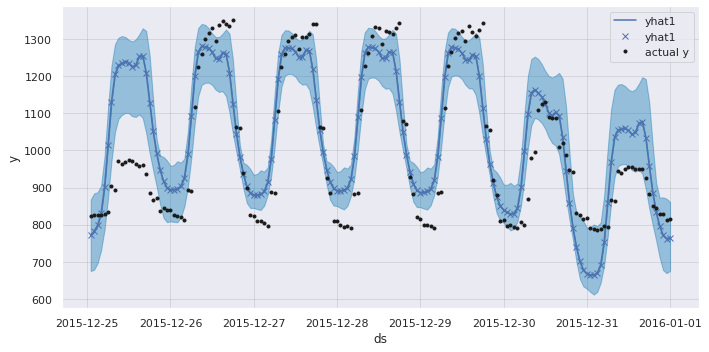

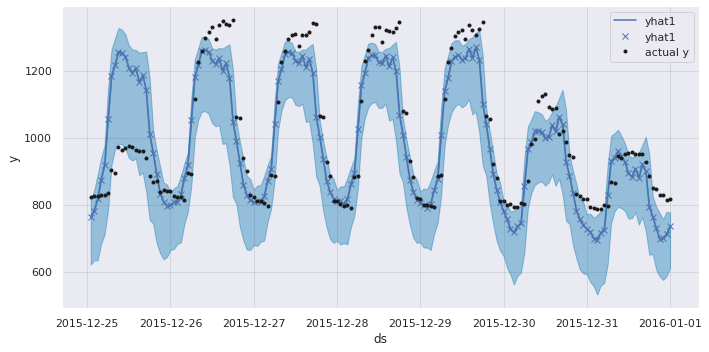

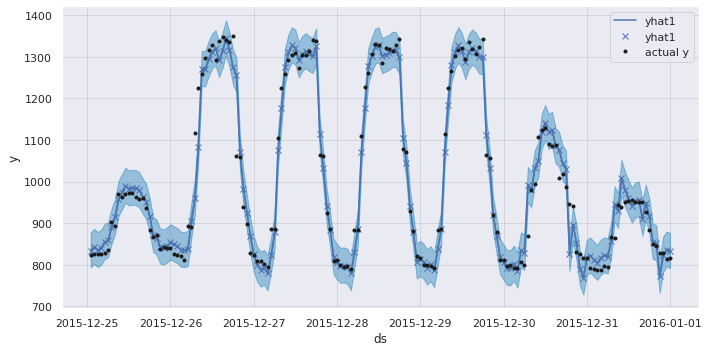

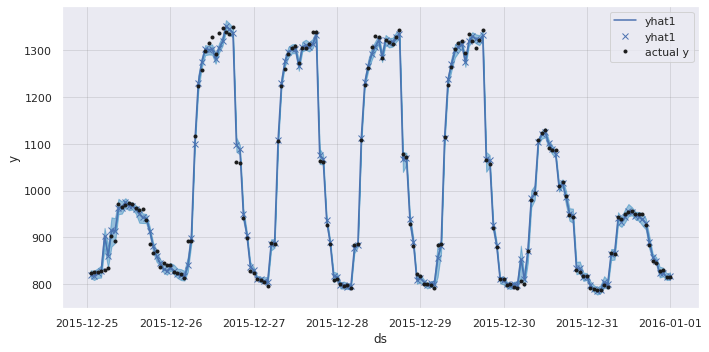

In [34]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1).plot(
    forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig3 = m3.highlight_nth_step_ahead_of_each_forecast(1).plot(
    forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig4 = m4.highlight_nth_step_ahead_of_each_forecast(1).plot(
    forecast4[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)

### Conformal predict and plot

**Naive**

In [35]:
method = "naive"
alpha = 0.1
plotting_backend = "matplotlib"  # "plotly", None
evaluate = True

Predicting: 234it [00:00, ?it/s]

Predicting: 234it [00:00, ?it/s]

Predicting: 234it [00:00, ?it/s]

Predicting: 234it [00:00, ?it/s]

Predicting: 232it [00:00, ?it/s]

Predicting: 232it [00:00, ?it/s]

Predicting: 232it [00:00, ?it/s]

Predicting: 232it [00:00, ?it/s]

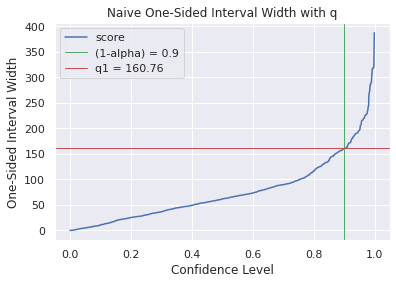

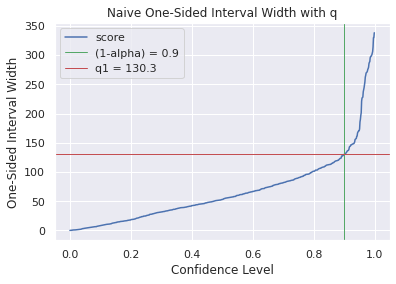

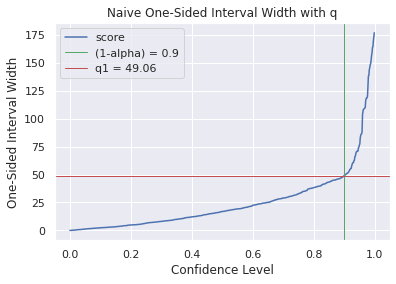

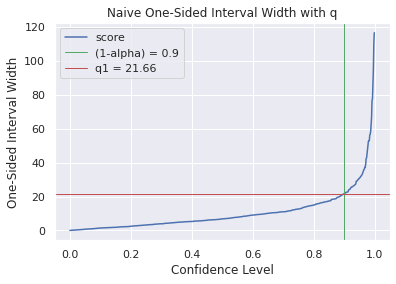

In [36]:
naive_forecast1, naive_eval1 = m1.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend=plotting_backend,
    evaluate=evaluate,
)
naive_forecast2, naive_eval2 = m2.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend=plotting_backend,
    evaluate=evaluate,
)
naive_forecast3, naive_eval3 = m3.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend=plotting_backend,
    evaluate=evaluate,
)
naive_forecast4, naive_eval4 = m4.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend=plotting_backend,
    evaluate=evaluate,
)

The plots above (m1 to m4) show the one-sided prediction interval width for a given confidence level. This one-sided prediction interval width is the `q` value from the sorted *nonconformity scores* from the Naive conformal prediction method. More specifically, this `q` value is the *nonconformity score* at the confidence level of 1 - `alpha`, or in this case 1 - 0.1 = 0.9. Finally, `q` is added on and subtracted from predicted value`y-hat` to form the full prediction interval. Hence `q` is also known as `q-hat`.

Below are the `q-hat` values models m1 - m4:

In [37]:
naive_qhat1 = naive_eval1["yhat1"].iloc[0]["qhat1"]
naive_qhat2 = naive_eval2["yhat1"].iloc[0]["qhat1"]
naive_qhat3 = naive_eval3["yhat1"].iloc[0]["qhat1"]
naive_qhat4 = naive_eval4["yhat1"].iloc[0]["qhat1"]

naive_qhat1, naive_qhat2, naive_qhat3, naive_qhat4

(160.75530026875003, 130.30437253437503, 49.055130528125005, 21.65865092343745)

Get forecasts and *naive* conformal prediction interval of OOS test_df

In [38]:
naive_forecast1 = naive_forecast1[n_lags:]
naive_forecast2 = naive_forecast2[n_lags:]
naive_forecast3 = naive_forecast3[n_lags:]
naive_forecast4 = naive_forecast4[n_lags:]

In [39]:
naive_forecast4.head()

ds            y        yhat1   yhat1 5.0%  yhat1 95.0%  \
72 2015-12-12 06:00:00   879.551547   883.944336   876.346191   888.811707   
73 2015-12-12 07:00:00  1102.066076  1111.180298  1092.691528  1122.760010   
74 2015-12-12 08:00:00  1214.971839  1228.296753  1217.268921  1241.771606   
75 2015-12-12 09:00:00  1257.597327  1265.819092  1254.519043  1274.899170   
76 2015-12-12 10:00:00  1293.807143  1297.054810  1285.453125  1308.629150   

           ar1       trend      qhat1  yhat1 - qhat1  yhat1 + qhat1  
72  -63.687786  947.632141  21.658651     862.285685     905.602987  
73  163.548203  947.632141  21.658651    1089.521647    1132.838949  
74  280.664581  947.632141  21.658651    1206.638102    1249.955404  
75  318.187012  947.632141  21.658651    1244.160441    1287.477743  
76  349.422699  947.632141  21.658651    1275.396159    1318.713460

Plot QR forecasts and *naive* conformal prediction intervals with OOS test_df

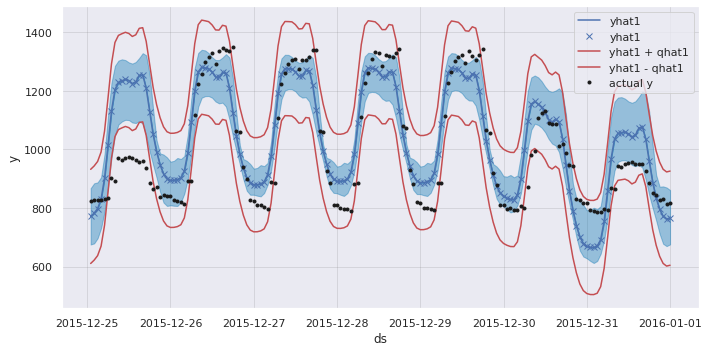

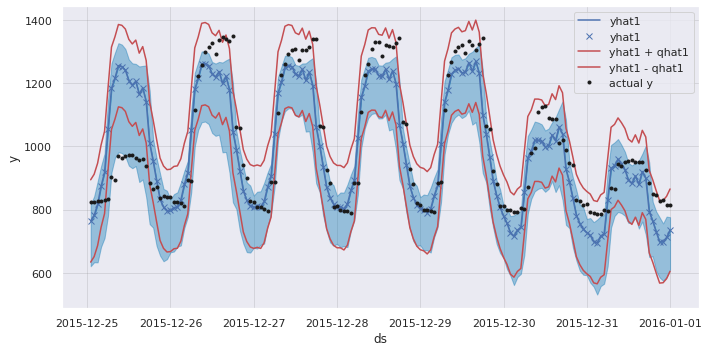

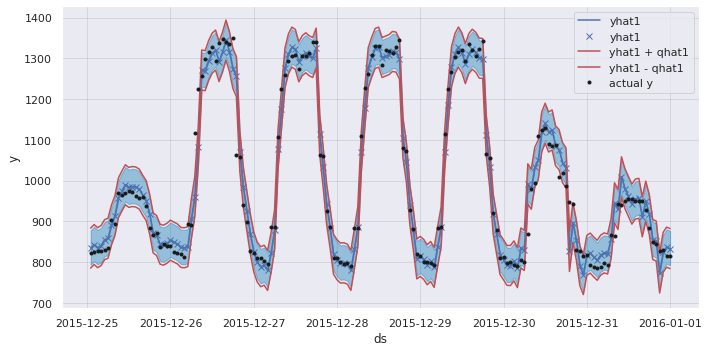

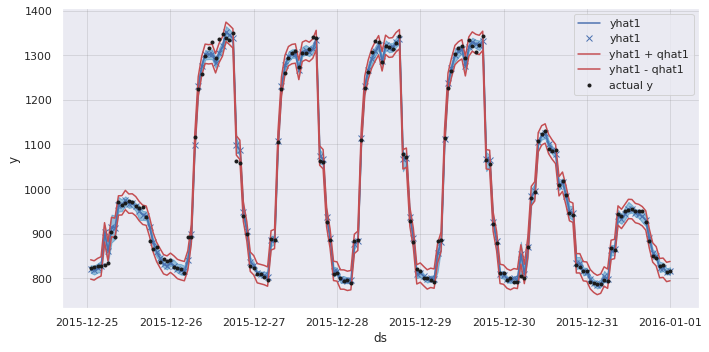

In [40]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1).plot(
    naive_forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    naive_forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig3 = m3.highlight_nth_step_ahead_of_each_forecast(1).plot(
    naive_forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig4 = m4.highlight_nth_step_ahead_of_each_forecast(1).plot(
    naive_forecast4[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)

**CQR**

In [41]:
method = "cqr"
alpha = 0.1
plotting_backend = "matplotlib"  # "plotly", None
evaluate = True

Predicting: 234it [00:00, ?it/s]

Predicting: 234it [00:00, ?it/s]

Predicting: 234it [00:00, ?it/s]

Predicting: 234it [00:00, ?it/s]

Predicting: 232it [00:00, ?it/s]

Predicting: 232it [00:00, ?it/s]

Predicting: 232it [00:00, ?it/s]

Predicting: 232it [00:00, ?it/s]

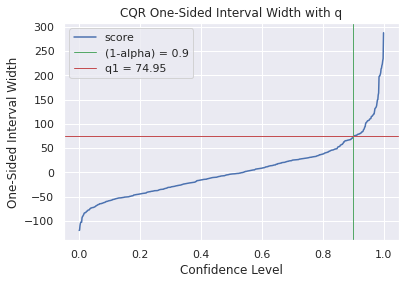

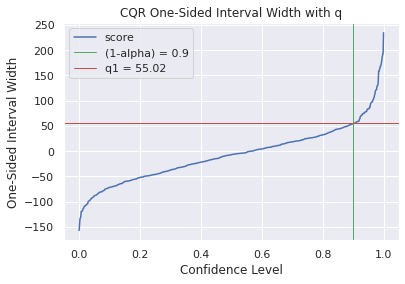

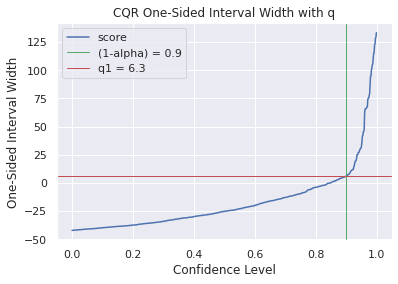

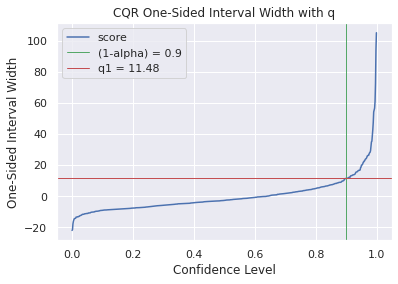

In [42]:
cqr_forecast1, cqr_eval1 = m1.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend=plotting_backend,
    evaluate=evaluate,
)
cqr_forecast2, cqr_eval2 = m2.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend=plotting_backend,
    evaluate=evaluate,
)
cqr_forecast3, cqr_eval3 = m3.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend=plotting_backend,
    evaluate=evaluate,
)
cqr_forecast4, cqr_eval4 = m4.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend=plotting_backend,
    evaluate=evaluate,
)

The plots above (m1 to m4) show the one-sided prediction interval width for a given confidence level. This one-sided prediction interval width is the `q` value from the sorted *nonconformity scores* from the CQR conformal prediction method. Unlike the Naive method, however, the CQR adjusts the prediction interval width of the existing quantile regression (QR).
- If the one-sided prediction interval width is **positive**, then CQR **extends** beyond the QR intervals, as it deems the QR interval to be too **confident**.
- Conversely, if the one-sided prediction interval width is **negative**, then CQR **contracts** the QR intervals, as it deems the QR interval to be too **conservative**.

Below are the `q-hat` values models m1 - m4. As they are all positive, you will see the CQR interval extending beyond that of QR. Model m1 has a large gap between these two intervals, while for m3, they are practically touching.  

In [43]:
cqr_qhat1 = cqr_eval1["yhat1"].iloc[0]["qhat1"]
cqr_qhat2 = cqr_eval2["yhat1"].iloc[0]["qhat1"]
cqr_qhat3 = cqr_eval3["yhat1"].iloc[0]["qhat1"]
cqr_qhat4 = cqr_eval4["yhat1"].iloc[0]["qhat1"]

cqr_qhat1, cqr_qhat2, cqr_qhat3, cqr_qhat4

(74.94919968203124, 55.019333671875074, 6.295553921874898, 11.481231328906233)

Get forecasts and *CQR* conformal prediction interval of OOS test_df

In [44]:
cqr_forecast1 = cqr_forecast1[n_lags:]
cqr_forecast2 = cqr_forecast2[n_lags:]
cqr_forecast3 = cqr_forecast3[n_lags:]
cqr_forecast4 = cqr_forecast4[n_lags:]

In [45]:
cqr_forecast4.head()

ds            y        yhat1   yhat1 5.0%  yhat1 95.0%  \
72 2015-12-12 06:00:00   879.551547   883.944336   876.346191   888.811707   
73 2015-12-12 07:00:00  1102.066076  1111.180298  1092.691528  1122.760010   
74 2015-12-12 08:00:00  1214.971839  1228.296753  1217.268921  1241.771606   
75 2015-12-12 09:00:00  1257.597327  1265.819092  1254.519043  1274.899170   
76 2015-12-12 10:00:00  1293.807143  1297.054810  1285.453125  1308.629150   

           ar1       trend      qhat1  yhat1 95.0% - qhat1  \
72  -63.687786  947.632141  11.481231           877.330475   
73  163.548203  947.632141  11.481231          1111.278778   
74  280.664581  947.632141  11.481231          1230.290375   
75  318.187012  947.632141  11.481231          1263.417939   
76  349.422699  947.632141  11.481231          1297.147919   

    yhat1 95.0% + qhat1  yhat1 5.0% - qhat1  yhat1 5.0% + qhat1  
72           900.292938          864.864960          887.827423  
73          1134.241241         1081.210297         1104.172760  
74          1253.252838         1205.787690         1228.750152  
75          1286.380401         1243.037812         1266.000274  
76          1320.110382         1273.971894         1296.934356

Plot QR forecasts and *CQR* conformal prediction interval with OOS test_df

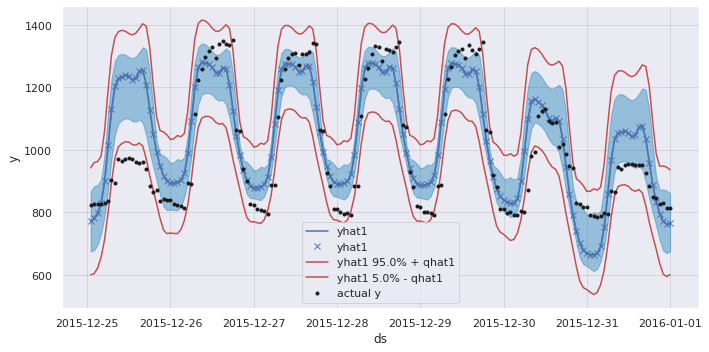

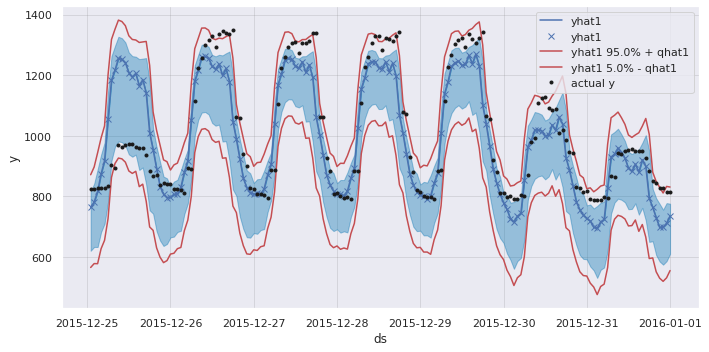

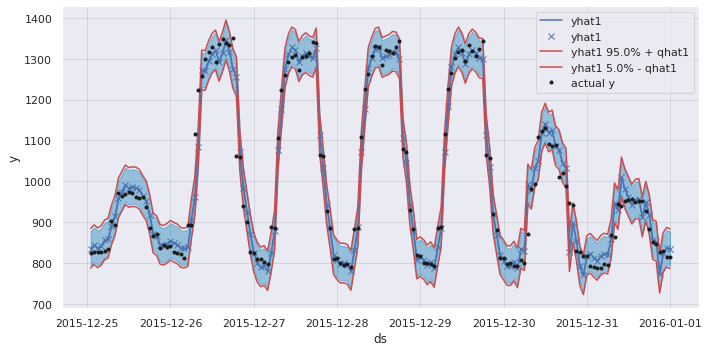

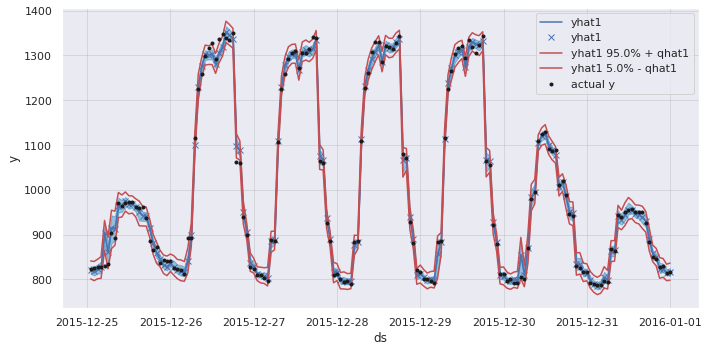

In [46]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig3 = m3.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig4 = m4.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast4[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)

### Evaluate Performance

- **interval_width**: The average prediction interval, or q_hat multiplied by 2 because it is static or non-adaptive. Also the *efficiency* metric.
- **miscoverage_rate**: The actual miscoverage error rate on the OOS test set. Also the *validity* metric.

For the both metrics, the lower the number, the better the performance.



**New**

In [93]:
models = ["m1", "m2", "m3", "m4"]
eval_df = pd.DataFrame(models, columns=pd.MultiIndex.from_tuples([("model", "", "")]))
eval_df

model
       
       
0    m1
1    m2
2    m3
3    m4

In [94]:
naive_evals = [naive_eval1, naive_eval2, naive_eval3, naive_eval4]
naive_eval_df = pd.concat(naive_evals).reset_index(drop=True)
naive_eval_df

yhat1                                
        qhat1 interval_width miscoverage_rate
0  160.755300     321.510601         0.107861
1  130.304373     260.608745         0.115174
2   49.055131      98.110261         0.210238
3   21.658651      43.317302         0.199269

In [95]:
cqr_evals = [cqr_eval1, cqr_eval2, cqr_eval3, cqr_eval4]
cqr_eval_df = pd.concat(cqr_evals).reset_index(drop=True)
cqr_eval_df

yhat1                                
       qhat1 interval_width miscoverage_rate
0  74.949200     309.629530         0.106033
1  55.019334     327.441861         0.122486
2   6.295554      97.042411         0.212066
3  11.481231      44.818693         0.193784

In [96]:
naive_eval_df

yhat1                                
        qhat1 interval_width miscoverage_rate
0  160.755300     321.510601         0.107861
1  130.304373     260.608745         0.115174
2   49.055131      98.110261         0.210238
3   21.658651      43.317302         0.199269

In [97]:
naive_eval_df.columns = pd.MultiIndex.from_tuples([(x[0], "naive", x[1]) for x in naive_eval_df.columns])
naive_eval_df

yhat1                                
        naive                                
        qhat1 interval_width miscoverage_rate
0  160.755300     321.510601         0.107861
1  130.304373     260.608745         0.115174
2   49.055131      98.110261         0.210238
3   21.658651      43.317302         0.199269

In [98]:
cqr_eval_df

yhat1                                
       qhat1 interval_width miscoverage_rate
0  74.949200     309.629530         0.106033
1  55.019334     327.441861         0.122486
2   6.295554      97.042411         0.212066
3  11.481231      44.818693         0.193784

In [99]:
cqr_eval_df.columns = pd.MultiIndex.from_tuples([(x[0], "cqr", x[1]) for x in cqr_eval_df.columns])
cqr_eval_df

yhat1                                
         cqr                                
       qhat1 interval_width miscoverage_rate
0  74.949200     309.629530         0.106033
1  55.019334     327.441861         0.122486
2   6.295554      97.042411         0.212066
3  11.481231      44.818693         0.193784

In [100]:
eval_df = pd.concat([eval_df, naive_eval_df, cqr_eval_df], axis=1)

In [101]:
eval_df

model       yhat1                                                            \
              naive                                        cqr                  
              qhat1 interval_width miscoverage_rate      qhat1 interval_width   
0    m1  160.755300     321.510601         0.107861  74.949200     309.629530   
1    m2  130.304373     260.608745         0.115174  55.019334     327.441861   
2    m3   49.055131      98.110261         0.210238   6.295554      97.042411   
3    m4   21.658651      43.317302         0.199269  11.481231      44.818693   

                    
                    
  miscoverage_rate  
0         0.106033  
1         0.122486  
2         0.212066  
3         0.193784

**Old**

In [102]:
conformal_methods = ["naive", "cqr"]
eval_df = pd.DataFrame(columns=pd.MultiIndex.from_product([conformal_methods, ["interval_width", "miscoverage_rate"]]))
eval_df = eval_df.reset_index().rename(columns={"index": "model"})

Enter in the model names

In [103]:
eval_df["model"] = ["m1", "m2", "m3", "m4"]

Enter in the **interval_width** (*efficiency* metric)

In [104]:
# Naive interval width
naive_iw = [naive_qhat1 * 2, naive_qhat2 * 2, naive_qhat3 * 2, naive_qhat4 * 2]
eval_df["naive", "interval_width"] = naive_iw

In [105]:
# Calculate CQR interval width function
def calc_cqr_iw(fcast_df, qr_lo, qr_hi, qhat):
    qr_lo_mean = fcast_df["yhat1"].mean() - fcast_df[f"yhat1 {qr_lo}%"].mean()
    qr_hi_mean = fcast_df[f"yhat1 {qr_hi}%"].mean() - fcast_df["yhat1"].mean()
    return qr_lo_mean + qr_hi_mean + qhat * 2

In [111]:
quantile_lo, quantile_hi = 0.05, 0.95

In [112]:
# Quantile low/high values in string (%) format
quantile_lo_str = str(quantile_lo * 100)
quantile_hi_str = str(quantile_hi * 100)

In [113]:
# CQR interval width
cqr_iw1 = calc_cqr_iw(cqr_forecast1, quantile_lo_str, quantile_hi_str, cqr_qhat1)
cqr_iw2 = calc_cqr_iw(cqr_forecast2, quantile_lo_str, quantile_hi_str, cqr_qhat2)
cqr_iw3 = calc_cqr_iw(cqr_forecast3, quantile_lo_str, quantile_hi_str, cqr_qhat3)
cqr_iw4 = calc_cqr_iw(cqr_forecast4, quantile_lo_str, quantile_hi_str, cqr_qhat4)

cqr_iw = [cqr_iw1, cqr_iw2, cqr_iw3, cqr_iw4]
eval_df["cqr", "interval_width"] = cqr_iw

Enter in the **miscoverage rate** (*validity* metric)

In [114]:
# Calculate Naive miscoverage rate function
def calc_naive_mr(fcast_df):
    n_covered = fcast_df.apply(lambda row: bool(row["yhat1 - qhat1"] <= row["y"] <= row["yhat1 + qhat1"]), axis=1)
    coverage_rate = n_covered.sum() / len(fcast_df)
    return 1 - coverage_rate

In [115]:
# Naive miscoverage rate
naive_mr1 = calc_naive_mr(naive_forecast1)
naive_mr2 = calc_naive_mr(naive_forecast2)
naive_mr3 = calc_naive_mr(naive_forecast3)
naive_mr4 = calc_naive_mr(naive_forecast4)

naive_mr = [naive_mr1, naive_mr2, naive_mr3, naive_mr4]
eval_df["naive", "miscoverage_rate"] = naive_mr

In [116]:
naive_qhat3 * 2, naive_mr3

(98.11026105625001, 0.09052631578947368)

In [117]:
n_covered = naive_forecast3.apply(lambda row: bool(row["yhat1 - qhat1"] <= row["y"] <= row["yhat1 + qhat1"]), axis=1)
coverage_rate = n_covered.sum() / len(naive_forecast3)
miscoverage_rate = 1 - coverage_rate
miscoverage_rate

0.09052631578947368

In [118]:
quantile_hi = str(max(quantiles) * 100)
quantile_lo = str(min(quantiles) * 100)

In [119]:
n_covered = cqr_forecast3.apply(
    lambda row: bool(row[f"yhat1 {quantile_lo}% - qhat1"] <= row["y"] <= row[f"yhat1 {quantile_hi}% + qhat1"]),
    axis=1,
)
coverage_rate = n_covered.sum() / len(cqr_forecast3)
miscoverage_rate = 1 - coverage_rate
miscoverage_rate

0.0926315789473684

In [92]:
naive_eval3

yhat1                                
       qhat1 interval_width miscoverage_rate
0  49.055131      98.110261         0.210238

In [69]:
# Calculate CQR and CQR Advanced miscoverage rate function
def calc_cqr_mr(fcast_df, qr_lo, qr_hi):
    n_covered = fcast_df.apply(
        lambda row: bool(row[f"yhat1 {qr_lo}% - qhat1"] <= row["y"] <= row[f"yhat1 {qr_hi}% + qhat1"]), axis=1
    )
    coverage_rate = n_covered.sum() / len(fcast_df)
    return 1 - coverage_rate

In [70]:
# CQR miscoverage rate
cqr_mr1 = calc_cqr_mr(cqr_forecast1, quantile_lo_str, quantile_hi_str)
cqr_mr2 = calc_cqr_mr(cqr_forecast2, quantile_lo_str, quantile_hi_str)
cqr_mr3 = calc_cqr_mr(cqr_forecast3, quantile_lo_str, quantile_hi_str)
cqr_mr4 = calc_cqr_mr(cqr_forecast4, quantile_lo_str, quantile_hi_str)

cqr_mr = [cqr_mr1, cqr_mr2, cqr_mr3, cqr_mr4]
eval_df["cqr", "miscoverage_rate"] = cqr_mr

In [71]:
cqr_mr3

0.0926315789473684

In [72]:
cqr_eval3

yhat1                                
      qhat1 interval_width miscoverage_rate
0  6.295554      97.042411         0.212066

Show evaluation dataframe

In [73]:
eval_df

model          naive                             cqr                 
        interval_width miscoverage_rate interval_width miscoverage_rate
0    m1     321.510601         0.111579     304.167136         0.111579
1    m2     260.608745         0.120000     325.856350         0.126316
2    m3      98.110261         0.090526      97.042411         0.092632
3    m4      43.317302         0.077895      44.818693         0.071579

In [74]:
eval_df

model          naive                             cqr                 
        interval_width miscoverage_rate interval_width miscoverage_rate
0    m1     321.510601         0.111579     304.167136         0.111579
1    m2     260.608745         0.120000     325.856350         0.126316
2    m3      98.110261         0.090526      97.042411         0.092632
3    m4      43.317302         0.077895      44.818693         0.071579

**Summary**:

- The more complex the model m1->m4, the more accurate it is, hence the lower *interval width* and *miscoverage rate* metrics. The weaker models m1 and m2 have *miscoverage rate* above *alpha* of 0.1 while the stronger NN models m3 and m4 have *miscoverage rate* below *alpha*.
- For default model m1, CQR outputs narrower prediction *interval width* than Naive while maintaining the same *miscoverage rate*.
- However, for biased seasonality model m2,the Naive method has a narrower prediction *interval width* with a slightly better *miscoverage rate* than CQR.
- For complex m3 and m4 models, Naive and CQR methods have comparable *interval_width* and *miscoverage rate*. More testing needs to be done in order to determine which method is preferable to the other under which circumstances.